In [1]:
using MGVI

In [2]:
using Distributions
using DelimitedFiles
using Random
using Optim
using StatsBase

In [3]:
using Plots

In [4]:
using FFTW

In [5]:
import ForwardDiff

In [6]:
Random.seed!(84612);

In [7]:
VERBOSE = false;

In [8]:
function read_coal_mining_data(filepath, binsize)
    init_year = empty
    data = empty
    open(filepath) do io
        raw = readline(io)
        while ! occursin("init_date", raw)
            raw = readline(io)
        end
        
        init_year = parse(Float64, split(split(strip(raw[2:end]), "\t")[2], "-")[1])
        data = readdlm(io, '\t', Int, '\n', comments=true)[:]
    end
    dates_fract_years = init_year .+ cumsum(data)/365
    left_edge = dates_fract_years[1]
    num_bins = ((dates_fract_years[end] - left_edge) ÷ binsize)
    right_edge = left_edge + binsize*num_bins
    fit(Histogram, dates_fract_years, left_edge:binsize:right_edge).weights
end

coal_mine_disaster_data = read_coal_mining_data("intervals.tsv", 1);

if VERBOSE
    print(coal_mine_disaster_data)
end

In [9]:
DATA_DIM = size(coal_mine_disaster_data, 1);

In [10]:
data = coal_mine_disaster_data;

In [11]:
DATA_XLIM = [1851., 1962.];

In [12]:
GP_GRAIN_FACTOR = 1;
GP_PADDING = 80;

In [13]:
function produce_bins()
    data_binsize = (DATA_XLIM[2] - DATA_XLIM[1])/DATA_DIM
    gp_binsize = data_binsize/GP_GRAIN_FACTOR
    gp_dim = Integer(((DATA_XLIM[2] - DATA_XLIM[1]) + 2*GP_PADDING) ÷ gp_binsize)
    gp_left_bin_offset = gp_right_bin_offset = (gp_dim - DATA_DIM) ÷ 2
    if (2*gp_left_bin_offset + DATA_DIM) % 2 == 1
        gp_left_bin_offset += 1
    end
    gp_left_xlim = DATA_XLIM[1] - gp_left_bin_offset*gp_binsize
    gp_right_xlim = DATA_XLIM[2] + gp_right_bin_offset*gp_binsize
    gp_left_xs = collect(gp_left_xlim + gp_binsize/2:gp_binsize:DATA_XLIM[1])
    gp_right_xs = collect(DATA_XLIM[2] + gp_binsize/2:gp_binsize:gp_right_xlim)
    gp_data_xs = collect(DATA_XLIM[1] + gp_binsize/2:gp_binsize:DATA_XLIM[2])
    gp_xs = [gp_left_xs; gp_data_xs; gp_right_xs]
    data_idxs = collect(gp_left_bin_offset+1:GP_GRAIN_FACTOR:gp_left_bin_offset+DATA_DIM)
    gp_xs, gp_binsize, data_idxs
end;

In [14]:
_GP_XS, _GP_BINSIZE, _DATA_IDXS = produce_bins();
_GP_DIM = length(_GP_XS);

In [15]:
function assemble_paridx(;kwargs...)
    pos = 0
    res = []
    for (k, v) in kwargs
        new_start, new_stop = v.start+pos, v.stop+pos
        push!(res, (k, (v.start+pos):(v.stop+pos)))
        pos = new_stop
    end
    (;res...)
end;

In [16]:
PARIDX = assemble_paridx(gp_hyper=1:2, gp_latent=1:_GP_DIM);

In [17]:
starting_point = randn(last(PARIDX).stop);

In [18]:
k = collect(0:(_GP_DIM)÷2 -1);

In [19]:
# squared exp model. sqrt of the covariance matrix in the Fourier space
function kernel_model(p) 
    kernel_A_c, kernel_l_c = p[PARIDX.gp_hyper]
    kernel_A = 60*exp(kernel_A_c*0.9)
    kernel_l = 0.025*exp(kernel_l_c/15)
    positive_modes = kernel_A .* sqrt(2 * π * kernel_l) .* exp.( -π^2 .* k.^2 .* kernel_l^2)
    negative_modes = positive_modes[end:-1:1]
    [positive_modes; negative_modes]
end;

if VERBOSE
    kernel_model(starting_point)
end

In [20]:
ht = FFTW.plan_r2r(zeros(_GP_DIM), FFTW.DHT);

In [21]:
function gp_sample(p)
    flat_gp = kernel_model(p) .* p[PARIDX.gp_latent]
    (ht * flat_gp) ./ _GP_DIM
end;

if VERBOSE
    gp_sample(starting_point)
end

In [22]:
function gp_sample(dp::Vector{ForwardDiff.Dual{T, V, N}}) where {T,V,N}
    flat_gp_duals = kernel_model(dp) .* dp[PARIDX.gp_latent]
    val_res = ht*ForwardDiff.value.(flat_gp_duals) ./ _GP_DIM
    psize = size(ForwardDiff.partials(flat_gp_duals[1]), 1)
    ps = x -> ForwardDiff.partials.(flat_gp_duals, x)
    val_ps = map((x -> ht*ps(x) ./ _GP_DIM), 1:psize)
    ForwardDiff.Dual{T}.(val_res, val_ps...)
end;

In [23]:
function poisson_gp_link(fs)
    exp.(fs)
end;

if VERBOSE
    poisson_gp_link(gp_sample(starting_point)) .* _GP_BINSIZE
end

In [24]:
function _forward_agg(data, idxs, steps_forward)
    [sum(data[i:i+steps_forward-1]) for i in idxs]
end;

In [25]:
function agg_lambdas(lambdas)
    gps = _forward_agg(lambdas, _DATA_IDXS, GP_GRAIN_FACTOR) .* _GP_BINSIZE
    xs = _GP_XS[_DATA_IDXS .+ (GP_GRAIN_FACTOR ÷ 2)]
    xs, gps
end;

function agg_full_lambdas(lambdas)
    left_idxs = 1:GP_GRAIN_FACTOR:(_DATA_IDXS[1]-1)
    left_gp = _forward_agg(lambdas, left_idxs, GP_GRAIN_FACTOR) .* _GP_BINSIZE
    left_xs = _GP_XS[left_idxs[1:GP_GRAIN_FACTOR:end] .+ (GP_GRAIN_FACTOR ÷ 2)]
    right_idxs = (_DATA_IDXS[end]+1):GP_GRAIN_FACTOR:size(lambdas, 1)
    right_gp = _forward_agg(lambdas, right_idxs, GP_GRAIN_FACTOR) .* _GP_BINSIZE
    right_xs = _GP_XS[right_idxs[1:GP_GRAIN_FACTOR:end] .+ (GP_GRAIN_FACTOR ÷ 2)]
    middle_xs, middle_gp = agg_lambdas(lambdas)
    full_xs = [left_xs; middle_xs; right_xs]
    full_gp = [left_gp; middle_gp; right_gp]
    full_xs, full_gp
end;

if VERBOSE
    agg_full_lambdas(poisson_gp_link(gp_sample(starting_point)))
end

In [26]:
function model(params)
    fs = gp_sample(params)
    fine_lambdas = poisson_gp_link(fs)
    _, lambdas = agg_lambdas(fine_lambdas)
    Product(Poisson.(lambdas))
end;

In [27]:
function _mean(p; full=false)
    agg_func = if (!full) agg_lambdas else agg_full_lambdas end
    xs, gps = agg_func(poisson_gp_link(gp_sample(p)))
    xs, gps
end;

In [28]:
function plot_mean(p, label="mean"; plot_args=(;), full=false)
    plot!(_mean(p; full=full)..., label=label, linewidth=2; plot_args...)
end;

In [29]:
function plot_prior_samples(num_samples)
    for _ in 1:num_samples
        p = randn(last(PARIDX).stop)
        plot_mean(p, nothing)
    end
end;

In [30]:
function plot_data(; scatter_args=(;), smooth_args=(;))
    scatter!(_GP_XS[_DATA_IDXS .+ (GP_GRAIN_FACTOR ÷ 2)], data, la=0, markersize=2., markerstrokewidth=0, label="data"; scatter_args...)
    smooth_step = 4
    smooth_xs = _GP_XS[_DATA_IDXS .+ (GP_GRAIN_FACTOR ÷ 2)][(smooth_step+1):(end-smooth_step)]
    smooth_data = [sum(data[i-smooth_step:i+smooth_step])/(2*smooth_step+1) for i in (smooth_step+1):(size(data, 1)-smooth_step)]
    plot!(smooth_xs, smooth_data, linewidth=2, linealpha=1, ls=:dash, label="smooth data"; smooth_args...)
end;

In [31]:
function plot_mgvi_samples(params)
    for sample in eachcol(params.samples)
        if any(isnan.(sample))
            print("nan found in samples", "\n")
            continue
        end
        plot!(_mean(Vector(sample))..., linealpha=0.5, linewidth=1, label=nothing)
    end
    plot!()
end;

In [32]:
function produce_posterior_samples(p, num_residuals)
    batch_size = 10
    
    if num_residuals <= 2*batch_size
        batch_size = num_residuals ÷ 2
    end
    
    est_res_sampler = MGVI._create_residual_sampler(model, p;
                                                    residual_sampler=ImplicitResidualSampler,
                                                    jacobian_func=FwdRevADJacobianFunc,
                                                    residual_sampler_options=(;cg_params=(;abstol=1E-2)))
    batches = []
    for _ in 1:(num_residuals ÷ batch_size ÷ 2)
        batch_residual_samples = MGVI.rand(Random.GLOBAL_RNG, est_res_sampler, batch_size)
        push!(batches, p .+ batch_residual_samples)
        push!(batches, p .- batch_residual_samples)
        if VERBOSE
            print(sum(size.(batches, 2)), "\n")
        end   
    end
    reduce(hcat, batches)
end

if VERBOSE
    produce_posterior_samples(next_iteration.result, 100)
end

In [33]:
function _extract_quantile(sorted_gp_realizations, p)
    map(s -> quantile(s, p; sorted=true), eachrow(sorted_gp_realizations))
end;

In [34]:
function plot_posterior_bands(p, num_samples; full=false)
    bands = [(0.997, :red), (0.955, :goldenrod1), (0.683, :green)]
    samples = produce_posterior_samples(p, num_samples)
    xs, first_gp = _mean(samples[1:end, 1]; full=full)
    gp_realizations = reduce(hcat, [_mean(Vector(sample); full=full)[2] for sample in eachcol(samples[1:end, 2:end])]; init=first_gp)
    for (i, one_x_sample) in enumerate(eachrow(gp_realizations))
        gp_realizations[i, 1:end] .= sort(Vector(one_x_sample))
    end
    for (band, color) in bands
        quant_l = _extract_quantile(gp_realizations, (1-band)/2)
        quant_u = _extract_quantile(gp_realizations, (1+band)/2)
        plot!(xs, quant_l; fillrange=quant_u, fillcolor=color, linealpha=0, label=band)
    end
    sample_median = _extract_quantile(gp_realizations, 0.5)
    plot!(xs, sample_median; linewidth=2, linecolor=:grey25, label="median")
end;

### Prior samples

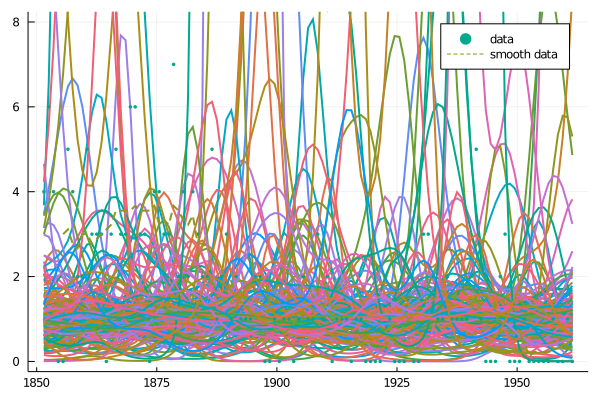

In [35]:
plot()
plot_prior_samples(200)
plot_data()
plot!(ylim=[0, 8])

### Fitting MGVI

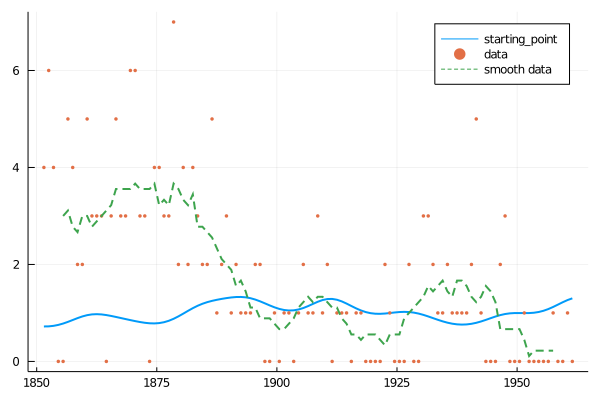

In [36]:
plot()
plot_mean(starting_point, "starting_point")
plot_data()

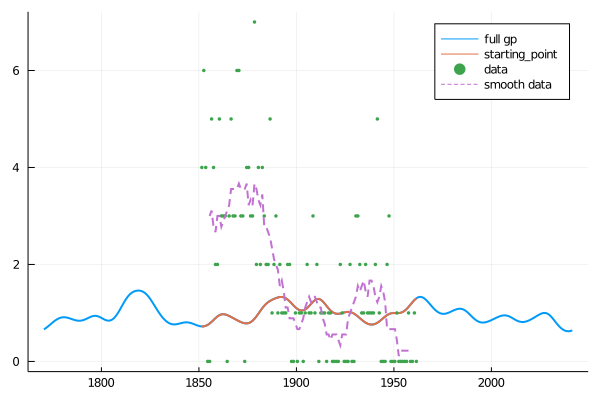

In [37]:
plot()
plot_mean(starting_point, "full gp"; full=true)
plot_mean(starting_point, "starting_point")
plot_data()

In [38]:
first_iteration = mgvi_kl_optimize_step(Random.GLOBAL_RNG,
                                        model, data,
                                        starting_point;
                                        num_residuals=3,
                                        jacobian_func=FwdRevADJacobianFunc,
                                        residual_sampler=ImplicitResidualSampler,
                                        optim_options=Optim.Options(iterations=1, show_trace=VERBOSE),
                                        residual_sampler_options=(;cg_params=(;abstol=1E-2,verbose=VERBOSE)));

if VERBOSE
    display(first_iteration)
end

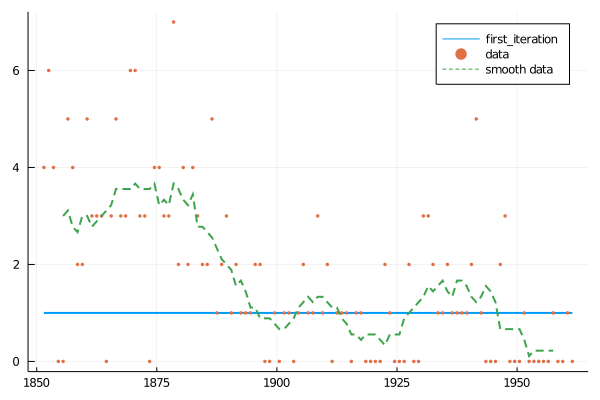

In [39]:
plot()
plot_mean(first_iteration.result, "first_iteration")
plot_data()

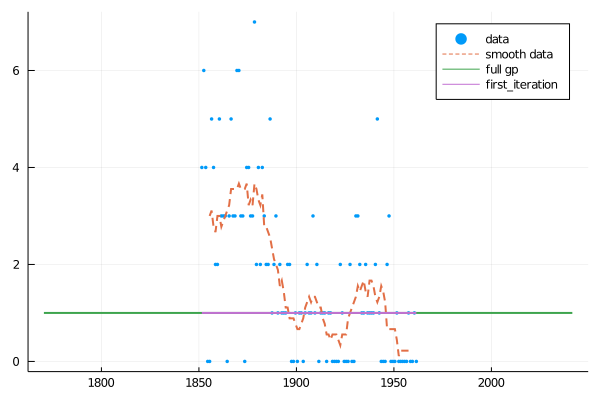

In [40]:
plot()
plot_data()
plot_mean(first_iteration.result, "full gp"; full=true)
plot_mean(first_iteration.result, "first_iteration")

In [41]:
function compute_avg_likelihood(model, samples, data)
    tot = 0
    for sample in eachcol(samples)
        tot += -MGVI.posterior_loglike(model, sample, data)
    end
    tot/size(samples, 2)
end;

In [42]:
next_iteration = first_iteration;
avg_likelihood_series = [];
push!(avg_likelihood_series, compute_avg_likelihood(model, next_iteration.samples, data));

In [43]:
function show_avg_likelihood(series)
    scatter!(1:size(series, 1), series, label="-loglike")
end;

In [44]:
for i in 1:20
    tmp_iteration = mgvi_kl_optimize_step(Random.GLOBAL_RNG,
                                          model, data,
                                          next_iteration.result;
                                          num_residuals=5,
                                          jacobian_func=FwdRevADJacobianFunc,
                                          residual_sampler=ImplicitResidualSampler,
                                          optim_options=Optim.Options(iterations=1, show_trace=VERBOSE),
                                          residual_sampler_options=(;cg_params=(;abstol=1E-2,verbose=VERBOSE)))
    next_iteration = tmp_iteration
    push!(avg_likelihood_series, compute_avg_likelihood(model, next_iteration.samples, data))
end;

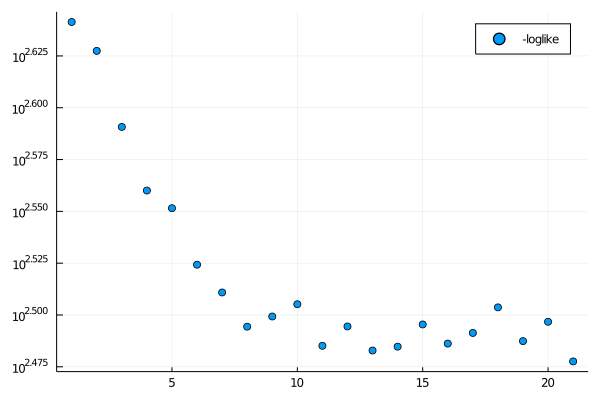

In [45]:
plot(yscale=:log)
show_avg_likelihood(avg_likelihood_series)

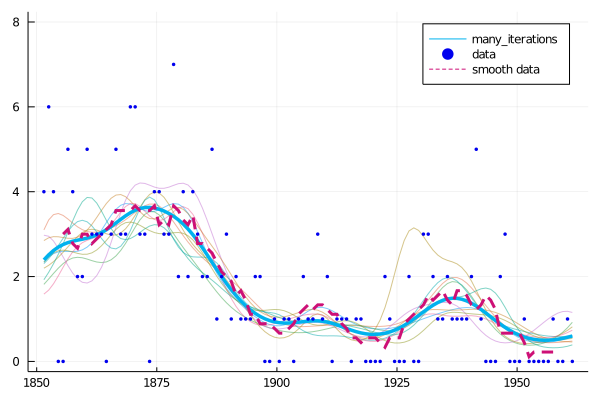

In [46]:
plot(ylim=[0,8])
plot_mgvi_samples(next_iteration)
plot_mean(next_iteration.result, "many_iterations", plot_args=(color=:deepskyblue2, linewidth=3.5))
plot_data(scatter_args=(;color=:blue2, marker_size=3.5), smooth_args=(;color=:deeppink3, linewidth=3))

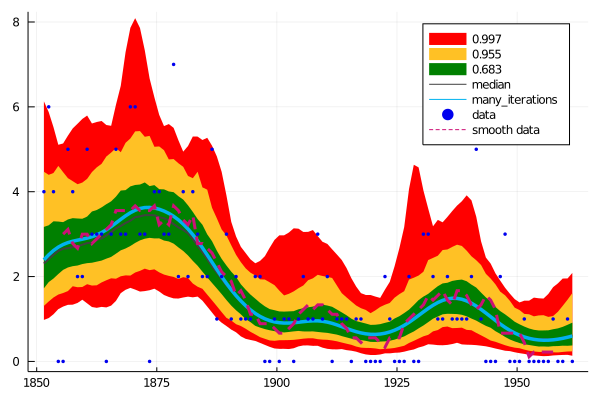

In [47]:
plot(ylim=[0,8])
plot_posterior_bands(next_iteration.result, 400)
plot_mean(next_iteration.result, "many_iterations", plot_args=(color=:deepskyblue2, linewidth=3.5))
plot_data(scatter_args=(;color=:blue2, marker_size=3.5), smooth_args=(;color=:deeppink3, linewidth=3))

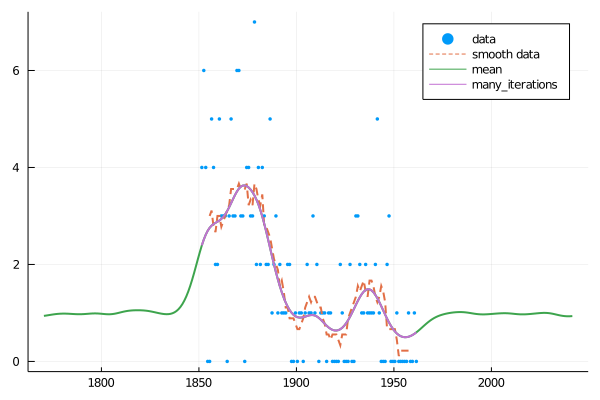

In [48]:
plot()
plot_data()
plot_mean(next_iteration.result; full=true)
plot_mean(next_iteration.result, "many_iterations")

### Maximum a posteriori estimation (MAP)

In [49]:
max_posterior = Optim.optimize(x -> -MGVI.posterior_loglike(model, x, data), starting_point, LBFGS(), Optim.Options(show_trace=VERBOSE, g_tol=1E-10, iterations=300));

if VERBOSE
    display(max_posterior)
end

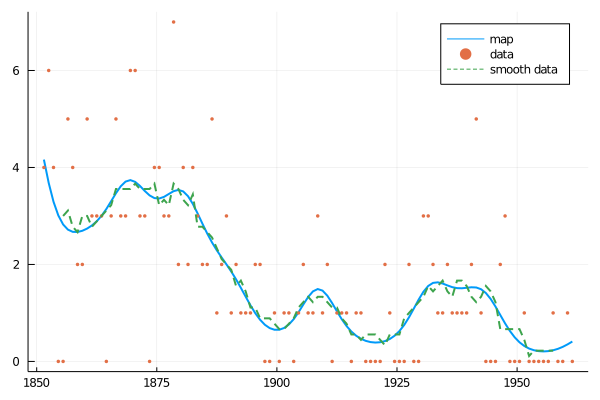

In [50]:
plot()
plot_mean(Optim.minimizer(max_posterior), "map")
plot_data()

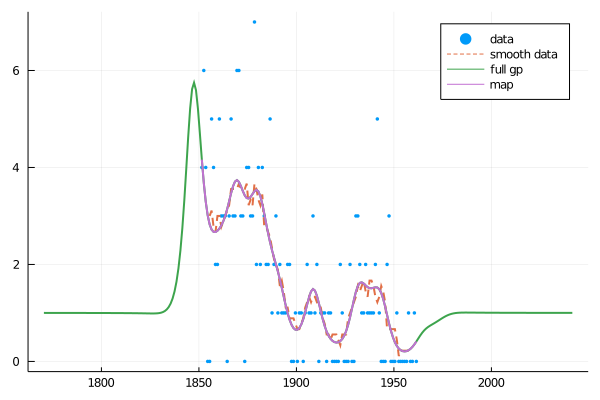

In [51]:
plot()
plot_data()
plot_mean(Optim.minimizer(max_posterior), "full gp"; full=true)
plot_mean(Optim.minimizer(max_posterior), "map")